# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, Constant, SequentialEvaluator, MultiprocessingEvaluator)

from ema_workbench.analysis import plotting, plotting_util

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench import Samplers

from ema_workbench.analysis.plotting import lines, Density

from pred import PredPrey

C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\connectors\__init__.py:32: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


In [10]:
py_model = Model("PurePythonModel", function=PredPrey)

# specify uncertainties
py_model.uncertainties = [
    RealParameter("prey_birth_rate", 0.015, 0.035),
    RealParameter("predation_rate", 0.0005, 0.003),
    RealParameter("predator_efficiency", 0.001, 0.004),
    RealParameter("predator_loss_rate", 0.04, 0.08),
]                           

# specify constants
py_model.constants = [
    Constant("initial_prey", 50),
    Constant("initial_predators", 20),
    Constant("dt", 0.25),
    Constant("final_time", 365),
]

# specify outcomes
py_model.outcomes = [
    TimeSeriesOutcome("TIME"),
    TimeSeriesOutcome("predators"),
    TimeSeriesOutcome("prey"),
]

In [11]:
experiments = {}
outcomes = {}

In [12]:
def run_seq(model, label, scenarios=1000, policies=0):
    with SequentialEvaluator(py_model) as evaluator:
        experiments[label], outcomes[label] = evaluator.perform_experiments(scenarios=scenarios, policies=policies)
    return

def run_par(model, label, scenarios=1000, policies=0):
    with MultiprocessingEvaluator(py_model) as evaluator:
        experiments[label], outcomes[label] = evaluator.perform_experiments(scenarios=scenarios, policies=policies)
    return

In [13]:
run_seq(py_model, "py", 250)

100%|███████████████████████████████████████| 250/250 [00:01<00:00, 191.66it/s]


In [14]:
outcomes = outcomes["py"]
experiments = experiments["py"]

In [15]:
outcomes["predators"]

array([[ 20.        ,  20.46236158,  20.93506272, ...,  68.97324495,
         68.87380314,  68.75565396],
       [ 20.        ,  20.09686534,  20.19606703, ..., 120.03744566,
        120.40733852, 120.75701665],
       [ 20.        ,  20.09476422,  20.19017245, ...,  34.08077095,
         34.11858577,  34.15455014],
       ...,
       [ 20.        ,  20.69904132,  21.42252046, ...,   0.74849252,
          0.74125151,   0.7341021 ],
       [ 20.        ,  20.31813859,  20.63845684, ...,   4.32709731,
          4.28683718,   4.24698112],
       [ 20.        ,  20.31088042,  20.62569242, ...,   3.22866276,
          3.20530475,   3.18218167]])

array([[20.        , 20.69064555, 21.3960661 , ...,  0.03501913,
         0.03567997,  0.03635753],
       [20.        , 20.27628676, 20.55224601, ...,  6.6978481 ,
         6.62728661,  6.55758328],
       [20.        , 20.50968084, 21.02538566, ...,  0.26304193,
         0.26050251,  0.25799581],
       ...,
       [20.        , 20.4818022 , 20.97565371, ...,  1.64688231,
         1.63274478,  1.61878199],
       [20.        , 20.46025551, 20.93075861, ...,  1.44663508,
         1.43628612,  1.42605914],
       [20.        , 20.10574546, 20.21209174, ..., 31.43576569,
        31.51332962, 31.58925369]])

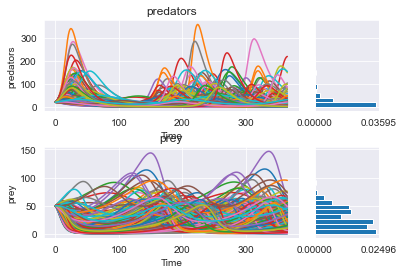

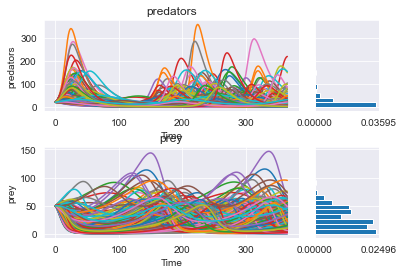

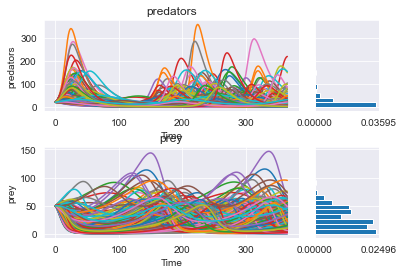

In [18]:
for outcome in outcomes.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=('predators', 'prey'), 
                   density=plotting_util.Density.HIST)
plt.show()